# Sourcing & Analyzing Time Series Data

### This script contains the following:

#### 1. Importing your Libraries and Data
#### 3. Subsetting, Wrangling, and Cleaning
#### 4. Line Chart
#### 5. Decompose Data's Components
#### 6. Dickey-Fuller Test for Stationarity
#### 7. Differencing our Data
#### 9. Rechecking Autocorrelations

# 1) Importing Libraries and Data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'gQcM5D_iiEk1Vur5knxz'

In [5]:
# Importing the Federal Reserve Economic Data "Gross Domestic Product(GDP); Sum of Pieces, Flow" variable.

data = quandl.get('FRED/GDPSOPQ027S')

In [6]:
# Checking our data
data.head()

,Value
Date,
1946-10-01,227707.0
1947-10-01,249619.0
1948-10-01,274467.0
1949-10-01,272472.0
1950-10-01,299829.0


In [7]:
# Understanding our data
data.shape

(285, 1)

In [8]:
data.columns

Index(['Value'], dtype='object')

# 3) Subsetting, Wrangling, Cleaning

We want to create a subset to filter out dates we don't need. For this example, we will only consider data that are from 1980 and beyond. Anything earlier than 1980 may incorrectly influence our calculations as economic conditions were very very different from 40's, 50's, etc.

In [11]:
# We will reset the index in order to use 'Date' column as a filter
data_2 = data.reset_index()

In [13]:
# Checking our work
# Now we have 2 columns, 'Date' and 'Value'
data_2.head()

,Date,Value
0,1946-10-01,227707.0
1,1947-10-01,249619.0
2,1948-10-01,274467.0
3,1949-10-01,272472.0
4,1950-10-01,299829.0


In [14]:
# Creating a subset
data_sub = data_2.loc[(data_2['Date'] >= '1980-01-01')]

In [15]:
# Checking our data
data_sub.head()

,Date,Value
118,1980-01-01,2789843.0
119,1980-04-01,2797353.0
120,1980-07-01,2856482.0
121,1980-10-01,2985556.0
122,1981-01-01,3124206.0


In [16]:
# Setting the "Date" column back as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1980-01-01,2789843.0
1980-04-01,2797353.0
1980-07-01,2856482.0
1980-10-01,2985556.0
1981-01-01,3124206.0


# 4) Line Chart

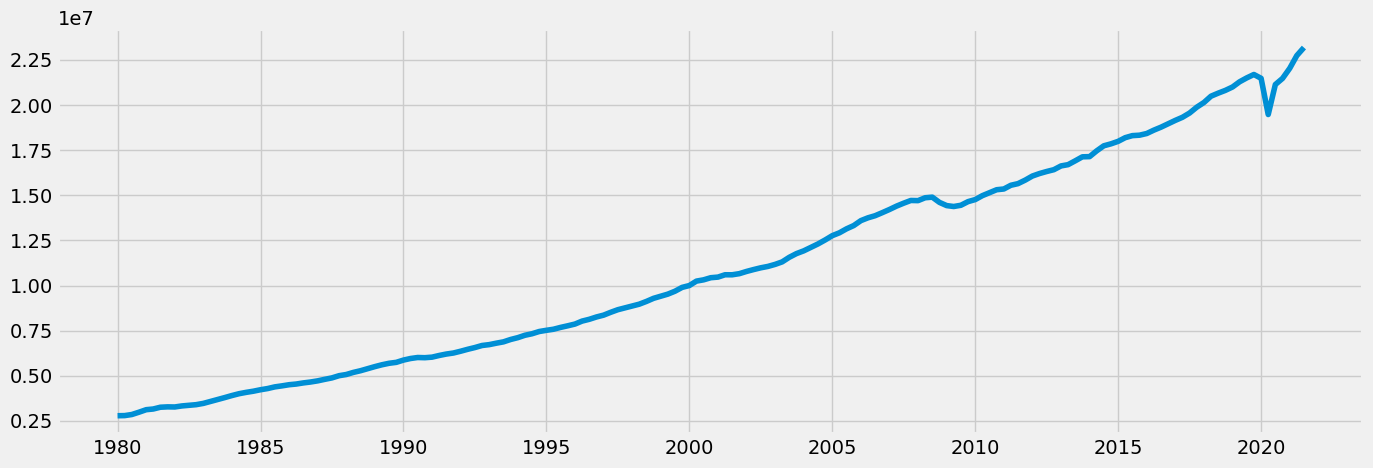

In [17]:
# Line Chart of new data

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

# 5) Decompose Data's Components

In [18]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [19]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

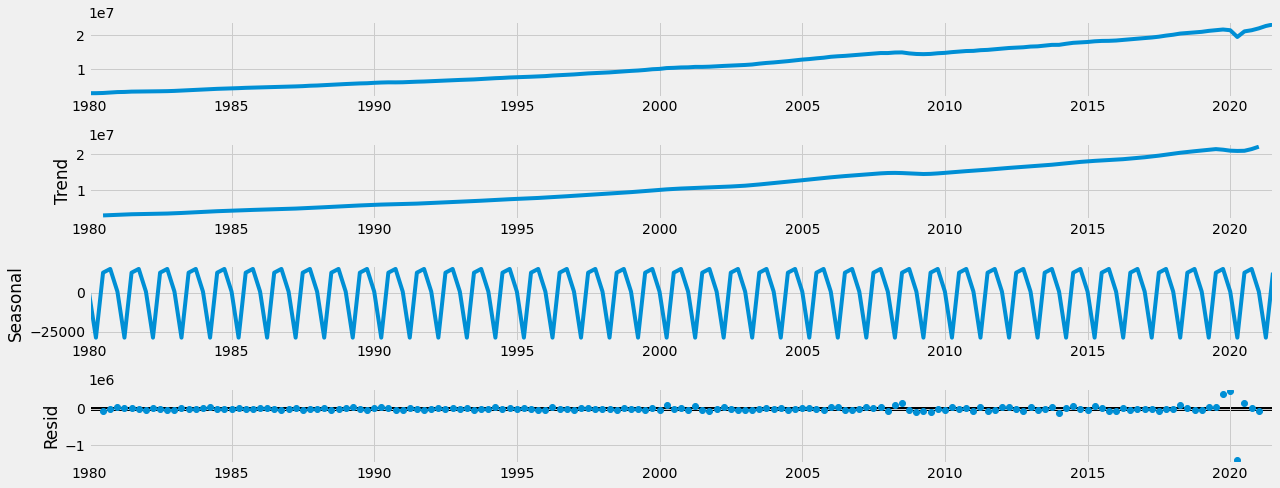

In [20]:
# Plot the separate components

decomposition.plot()
plt.show()

# 6) Dickey-Fuller Test for Stationarity

In [21]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   3.110948
p-value                          1.000000
Number of Lags Used              8.000000
Number of Observations Used    158.000000
Critical Value (1%)             -3.472431
Critical Value (5%)             -2.880013
Critical Value (10%)            -2.576619
dtype: float64


Null Hypothesis: there IS a unit root

Alternative Hypothesis: there is NO unit root

Since the Test Statistic (3.11) is much greater than any Critical Value, we CAN'T reject the null hypothesis, meaning there is a unit root.

### Test for Autocorrelations

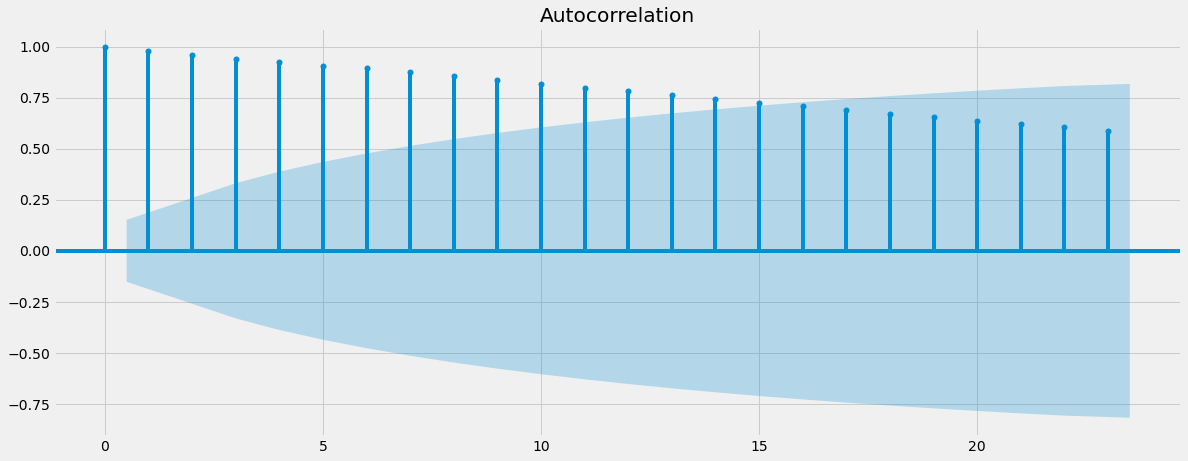

In [22]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

Data is clearly non-stationary due to lags being significantly correlated with one another.

# 7) Differencing our Data

In [23]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [24]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [25]:
data_diff.head()

,Value
datetime,
1980-04-01,7510.0
1980-07-01,59129.0
1980-10-01,129074.0
1981-01-01,138650.0
1981-04-01,38325.0


In [26]:
data_diff.columns

Index(['Value'], dtype='object')

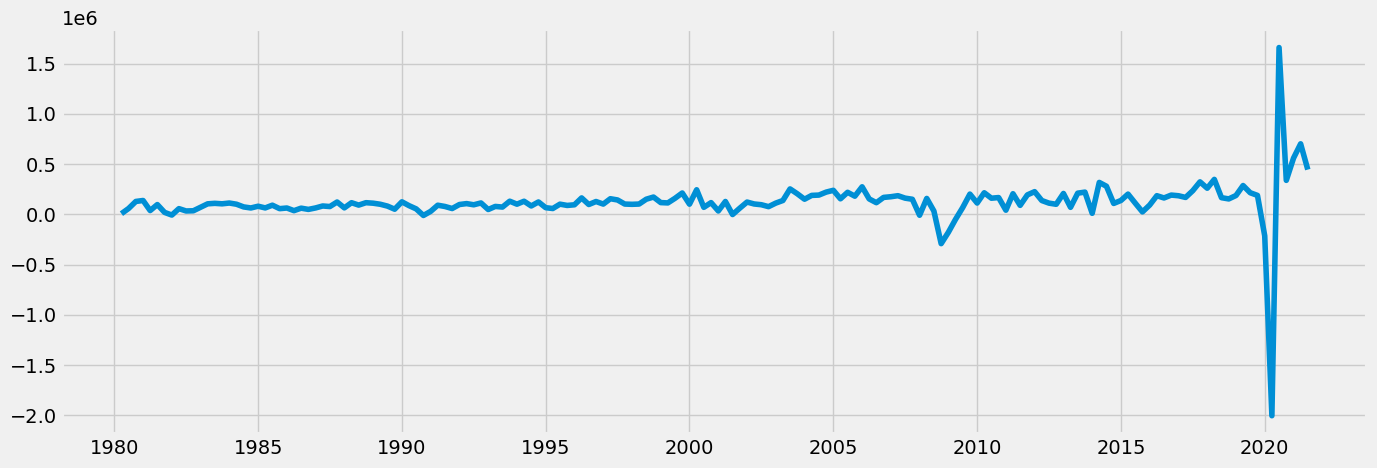

In [27]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

# 6) Repeat to Test for Stationarity

In [28]:
# Repeat Dickey Fuller test with new data
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -4.365611
p-value                          0.000341
Number of Lags Used              7.000000
Number of Observations Used    158.000000
Critical Value (1%)             -3.472431
Critical Value (5%)             -2.880013
Critical Value (10%)            -2.576619
dtype: float64


Test Statistic (-4.3656) IS less than all three Critical Values, therefore our Null Hypothesis has been REJECTED.

# 9) Rechecking Autocorrelations

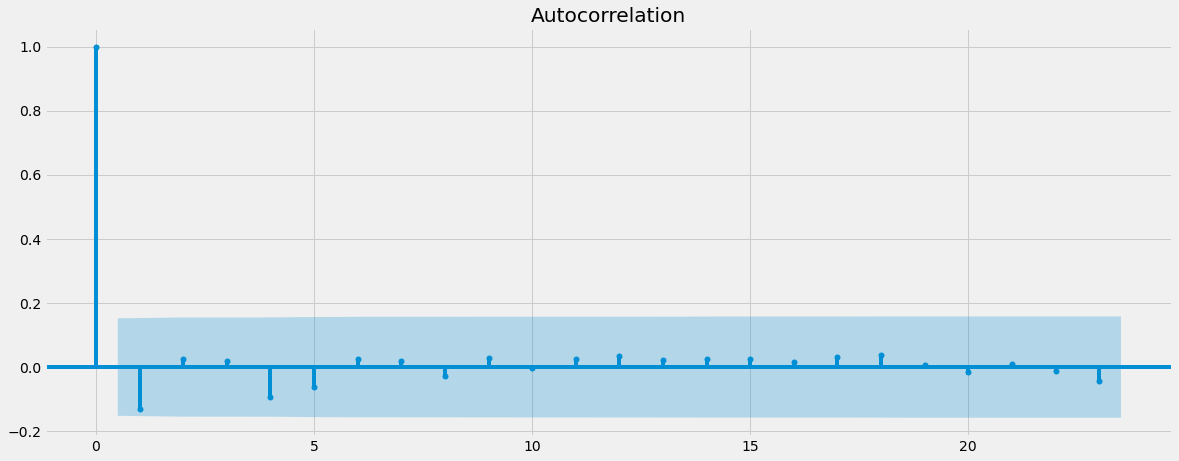

In [29]:
# Checking new data's autocorrelations
plot_acf(data_diff)
plt.show()